In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat # loading data from matlab
import pbdlib as pbd
import pbdlib.plot
import os
from pbdlib.utils.jupyter_utils import *
np.set_printoptions(precision=2)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Example 1: 2D regression problem

In [2]:
N = 500
x_dim = 1
y_dim = 1


x = np.concatenate([np.linspace(-10., 10., N)[None],
                    np.linspace(-20, 10., N)[None]], axis=0).T
A = np.array([[0.8 , -3. ],
              [0.5, 1. ],
              [4. ,  7. ]])
b = np.arange(y_dim)
y = np.sin(x[:,:x_dim].dot(A[:y_dim, :x_dim].T) + b[:y_dim])

x = np.float32(x[:,:x_dim])
y = np.float32(y + np.concatenate([
    np.random.normal(size=(int(N/2),y_dim))*1.2,
    np.random.normal(size=(int(N/2),y_dim))*0.5
], axis=0))

In [3]:
T_train = 50
ind = np.sort(np.random.choice(range(0,N), T_train, replace=False))

In [4]:
plot_dimx = 0
plot_dimy = 0

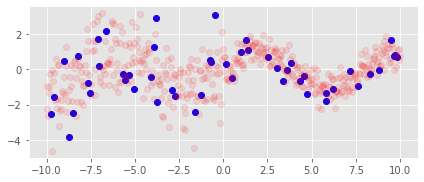

In [5]:
fig,ax = plt.subplots()
ax.plot(x[ind,plot_dimx], y[ind,plot_dimy],"o", color="b")
ax.plot(x[:,plot_dimx], y[:,plot_dimy], "o", color="r", alpha = 0.1)
ax.set_aspect('equal', 'box')
fig.tight_layout()

In [6]:
x_joint = np.concatenate([x[ind],y[ind]],axis=-1)
n_joint = x_joint.shape[-1]

In [7]:
nb_states = 10

joint_model = pbd.VBayesianGMM({
'n_components': nb_states, 'n_init': 5})
joint_model.posterior(data=x_joint)
print("Used state number: ", joint_model.get_used_states().nb_states, "out of ", nb_states)

Used state number:  2 out of  10


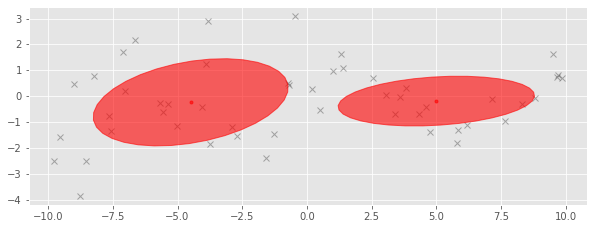

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(x_joint[:, 0], x_joint[:, 1],"kx",alpha=0.3)
joint_model.get_used_states().plot(dim=[0, 1], ax=ax, alpha=0.6)
ax.set_aspect('equal', 'box')

In [9]:
sample_size=20
x_samples = np.zeros((sample_size, x.shape[0], 1))
for i,xi in enumerate(x):
    conditional_model = joint_model.condition(xi, dim_in=slice(0,1),dim_out=slice(1,2))
    x_samples[:,i] = conditional_model.sample(sample_size) 

In [10]:
d = 20.
inp = np.array([x-d,x, x+d]).reshape((-1,1))
x_samples_tot = np.zeros((sample_size, inp.shape[0], 1))
x_samples_al  = np.zeros((sample_size, inp.shape[0], 1))
x_samples_ep  = np.zeros((sample_size, inp.shape[0], 1))
for i,xi in enumerate(inp):
    conditional_model = joint_model.condition(xi,
                                              dim_in=slice(0,1),
                                              dim_out=slice(1,2),
                                              return_aleatoric=True,
                                              return_epistemic=True)
    x_samples_tot[:,i] = conditional_model.sample(sample_size) 
    x_samples_al[:,i] = joint_model.aleatoric.sample(sample_size)
    x_samples_ep[:,i] = joint_model.epistemic.sample(sample_size)

In [11]:
x_samples_far = [x_samples_tot[...,0], x_samples_al[...,0], x_samples_ep[...,0]]

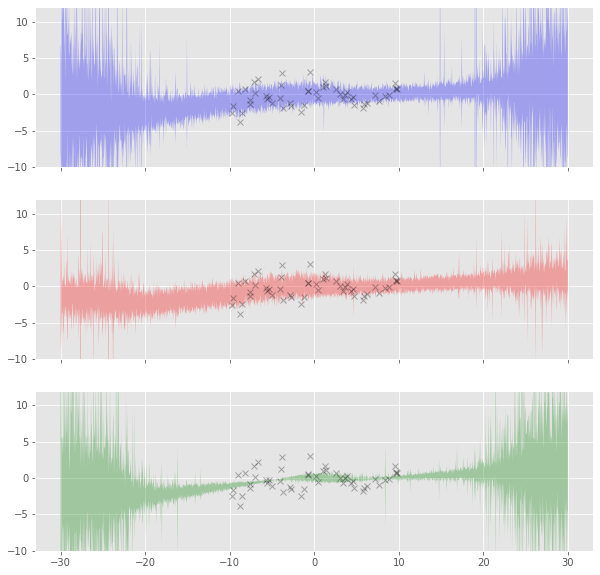

In [12]:
fig, ax = plt.subplots(nrows = 3, figsize=(10,10),sharex=True, sharey=True)
colors = ["b", "r", "g"]

for c in range(3):
    ax[c].plot(x_joint[:, 0], x_joint[:, 1],'kx', alpha=0.3)
    ax[c].fill_between(inp[:,0],
                        np.mean(x_samples_far[c],axis=0)-1*np.std(x_samples_far[c],axis=0),
                        np.mean(x_samples_far[c],axis=0)+1*np.std(x_samples_far[c],axis=0),
                        facecolor=colors[c],
                        alpha=0.3)
    ax[c].set_ylim([-10,12])

In [13]:
conditional = joint_model.condition(inp,
                                    dim_in=slice(0,1),
                                    dim_out=slice(1,2),
                                    return_aleatoric=True,
                                    return_epistemic=True
                                   )

In [14]:
aleatoric = joint_model.aleatoric
epistemic = joint_model.epistemic
total     = conditional

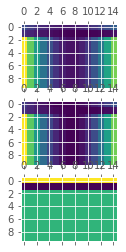

In [15]:
fig,ax= plt.subplots(3)
ax[0].matshow(total.sigma[:,0:-1:100,0,0])
ax[1].matshow(epistemic.sigma[:,0:-1:100,0,0])
ax[2].matshow(aleatoric.sigma[:,0:-1:100,0,0])

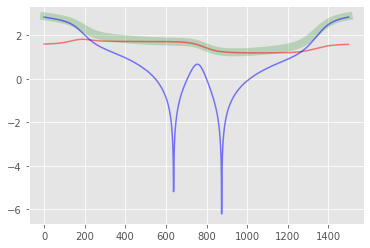

In [17]:
# Uncertainty Plot
plt.plot(pbd.utils.renyi_entropy(total),"g",lw=8,alpha=0.2)
plt.plot(pbd.utils.renyi_entropy(aleatoric),"r",alpha=0.5)
plt.plot(pbd.utils.renyi_entropy(epistemic),"b",alpha=0.5)